In [1]:
import re
import pickle
import numpy as np
import tomotopy as tp

from tqdm import tqdm

from rdkit.Chem.inchi import MolFromInchi
from rdkit.Chem import MolToSmiles
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage

from MS2LDA.utils import retrieve_spec4doc
from MS2LDA.modeling import extract_motifs, create_motif_spectra
from MS2LDA.motif_parser import load_m2m_folder

from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as calc_fingerprints

from matchms.similarity import CosineGreedy
cosine_greedy = CosineGreedy(tolerance=0.2)

In [ ]:
# Ensure MS2LDA can be imported
import sys
from pathlib import Path
# Add parent directory to path if MS2LDA not already importable
try:
    import MS2LDA
except ImportError:
    sys.path.insert(0, str(Path.cwd().parent.parent))
    import MS2LDA

normally I could just load the m2m folder, but there was a bug in the code that overwrote the motif_id. If only 20 paramters are selected, some Mass2Motifs consist only of losses and they can be valuable but with the current spec2vec this is not possible to predict them. Also a Mass2Motif object should then be used instead of the current spectrum object. Right now, these motifs are removed and therefore instead of 2000 Mass2Motifs only 1951 Mass2Motifs are returned. By enumerating over the Mass2Motifs and giving them a new id (this was the bug), the information Mass2Motif id information is lost in the m2m files. <br>
As long as the ms2lda.bin file is available all data can be correctly retrieved.

---

In [2]:
motif_spectra = load_m2m_folder("CaseStudy_Suspectlist_2500motifs_output/motifs")
#motif_spectra = load_m2m_folder("DDA-Suspectlist-250motifs_output/motifs")

In [3]:
len(motif_spectra)

2500

In [4]:
with open("CaseStudy_Suspectlist_2500motifs_output/doc2spec_map.pkl", "rb") as f:
#with open("DDA-Suspectlist-250motifs_output/doc2spec_map.pkl", "rb") as f:
    doc2spec_map = pickle.load(f)

In [10]:
ms2lda = tp.LDAModel.load("CaseStudy_Suspectlist_2500motifs_output/ms2lda.bin")
#ms2lda = tp.LDAModel.load("DDA-Suspectlist-250motifs_output/ms2lda.bin")

Exception: 'CaseStudy_Suspectlist_2500motifs_output/ms2lda.bin' is not valid model file

In [ ]:
n_docs = len(ms2lda.docs)
print("Number of spectra used for modeling MS2LDA: ", n_docs)

In [ ]:
def calc_tanimoto(fp1, fp2):
    fp1 = np.asarray(fp1, dtype=bool)
    fp2 = np.asarray(fp2, dtype=bool)

    intersection = np.logical_and(fp1, fp2).sum()
    union = np.logical_or(fp1, fp2).sum()

    return intersection / union

In [ ]:
def inchi2smiles(inchi):
    # get only inchi code
    inchi = re.search(r'((InChI=)?1S\S*)', inchi)
    if inchi:
        inchi = inchi.group(1).replace('"','')
        if inchi.startswith("1S"):
            mol = MolFromInchi("InChI="+inchi)
        else:
            mol = MolFromInchi(inchi)
        
        if mol:
            smiles = MolToSmiles(mol)
            return smiles, inchi
        else:
            return None, None
    else:
        return None, None

---

In [ ]:
next((motif_spec for motif_spec in motif_spectra if motif_spec.get("id") == f"motif_{409}"))

---

In [77]:
n_not_inchis

30203

In [78]:
n_not_smiles

0

In [79]:
len(promising_doc_ids)

1015

In [80]:
len(set(promising_top_2_motif_ids))

446

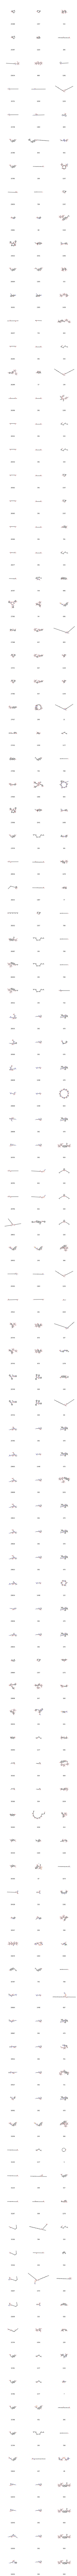

In [81]:
MolsToGridImage([MolFromSmiles(smi) for smi_triple in smiles_triple[300:400] for smi in smi_triple], legends=[str(_id) for ids in list(zip(promising_doc_ids, promising_top_1_motif_ids, promising_top_2_motif_ids))[300:400] for _id in ids], molsPerRow=3, subImgSize=(300,300), maxMols=200*3)

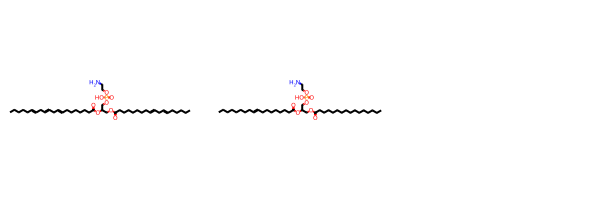

In [67]:
spec_3 = next((motif_spec for motif_spec in motif_spectra if motif_spec.get("id") == f"motif_{409}"))
MolsToGridImage([MolFromSmiles(smi) for smi in eval(spec_3.get("auto_annotation"))])

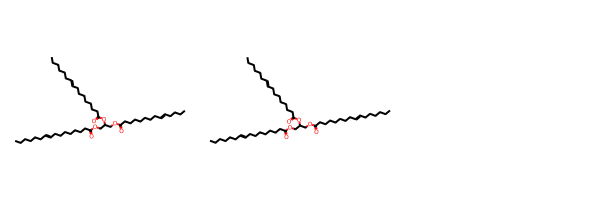

In [72]:
spec_4 = next((motif_spec for motif_spec in motif_spectra if motif_spec.get("id") == f"motif_{1356}"))
MolsToGridImage([MolFromSmiles(smi) for smi in eval(spec_4.get("auto_annotation"))])